In [27]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [28]:
random.seed = 20

#### Load training dataset

In [29]:
# Root
from MyDataset import MyDataset

root = '../../train_val_test_dataset/IEEE_Case118/UC'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

In [30]:
# Get train dataset
train_size = 7000

train_dataset = dataset[:train_size]

# Create train loader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

#### Load model

In [31]:
from GNNClassifier import GNNClassifier

In [32]:
# Set hyper-parameters
input_dim = 32
hidden_dim1 = 256
hidden_dim2 = 64
hidden_dim3 = 24
output_dim = 12
num_gnn_layers = 3
drop_rate = 0.3

# Set device
device = 'gpu' if torch.cuda.is_available() else 'cpu'

In [33]:
# Initialize the model
model = GNNClassifier(input_dim, hidden_dim1, 
                      hidden_dim2, hidden_dim3, 
                      output_dim, num_gnn_layers, 
                      drop_rate)
model.to(device)

GNNClassifier(
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (gnn): ModuleList(
    (0): GCNConv(64, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 64)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=12, bias=True)
    (3): Sigmoid()
  )
)

#### Train model

In [34]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

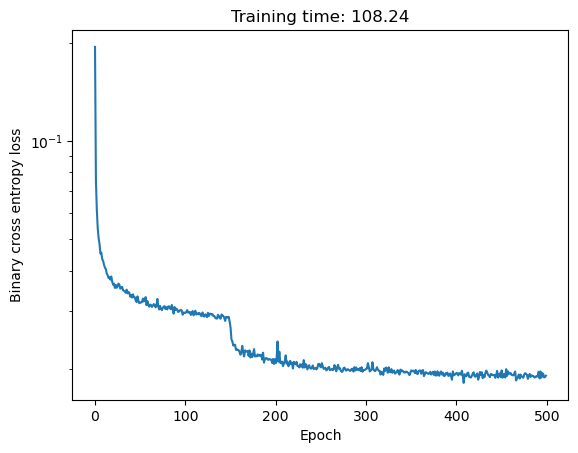

In [35]:
# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index, loader.edge_attr)

        loss = F.binary_cross_entropy(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Binary cross entropy loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save model

In [36]:
torch.save(model, './trained_model/UC_model.pt')